# Strong Scaling Analysis: Burgers Equation Solver

**Focus: Strong scaling performance analysis**

Note: Weak scaling is not analyzed here because explicit diffusion schemes have dt ∝ dx², 
causing timesteps to scale as P² when problem size scales with P. This makes weak scaling 
fundamentally unsuitable for explicit methods.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import re

plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 11

import os
os.makedirs('plots', exist_ok=True)

RESULTS_DIR = Path('plgrid_results')

## Load Strong Scaling Results

In [23]:
# Load strong scaling results
strong_results = {}
pattern_strong = r'burgers_strong_nx(\d+)_P(\d+)\.npz'

for npz_file in RESULTS_DIR.glob('burgers_strong_*.npz'):
    match = re.search(pattern_strong, npz_file.name)
    if match:
        nx = int(match.group(1))
        n_procs = int(match.group(2))
        data = np.load(npz_file)
        
        if nx not in strong_results:
            strong_results[nx] = {}
        
        strong_results[nx][n_procs] = {
            'time': float(data['elapsed_time']),
            'n_steps': int(data['n_steps']),
            'nx': nx
        }

print(f"[OK] Loaded strong scaling for {len(strong_results)} grid sizes:")
for nx in sorted(strong_results.keys()):
    procs = sorted(strong_results[nx].keys())
    print(f"  nx={nx}: P={procs}")

# Load shock wave results
shock_files = list(RESULTS_DIR.glob('burgers_shock_*.npz'))
print(f"\n[OK] Found {len(shock_files)} shock wave demonstrations")

[OK] Loaded strong scaling for 3 grid sizes:
  nx=1200: P=[1, 2, 4, 8]
  nx=2400: P=[1, 4, 8, 16]
  nx=4800: P=[1, 4, 8, 16, 24]

[OK] Found 1 shock wave demonstrations


## Weak Scaling Results (For Comparison)

**Note:** These results demonstrate the fundamental limitation of explicit diffusion schemes. The poor scaling is expected and mathematically unavoidable (see WEAK_SCALING_EXPLANATION.md for details).

In [24]:
# Load weak scaling results
weak_results = {}
pattern_weak = r'burgers_weak_nx(\d+)_P(\d+)\.npz'

for npz_file in RESULTS_DIR.glob('burgers_weak_*.npz'):
    match = re.search(pattern_weak, npz_file.name)
    if match:
        nx = int(match.group(1))
        n_procs = int(match.group(2))
        data = np.load(npz_file)
        
        weak_results[n_procs] = {
            'nx': nx,
            'time': float(data['elapsed_time']),
            'n_steps': int(data['n_steps']),
            'cells_per_proc': nx // n_procs
        }

if weak_results:
    print(f"[OK] Loaded {len(weak_results)} weak scaling results")
    print(f"\nWeak Scaling Data (constant {list(weak_results.values())[0]['cells_per_proc']} cells/proc):")
    print(f"{'P':>4} {'nx':>8} {'Steps':>12} {'Time[s]':>10}")
    print("-" * 40)
    for p in sorted(weak_results.keys()):
        r = weak_results[p]
        print(f"{p:4d} {r['nx']:8d} {r['n_steps']:12d} {r['time']:10.2f}")
else:
    print("[Note] No weak scaling results found")

[OK] Loaded 5 weak scaling results

Weak Scaling Data (constant 300 cells/proc):
   P       nx        Steps    Time[s]
----------------------------------------
   1      300        10800       0.52
   4     1200       172800      10.84
   8     2400       691201      44.31
  16     4800      2764801     224.67
  24     7200      6220801     527.08



[OK] Saved: plots/WEAK_SCALING_LIMITATION.png


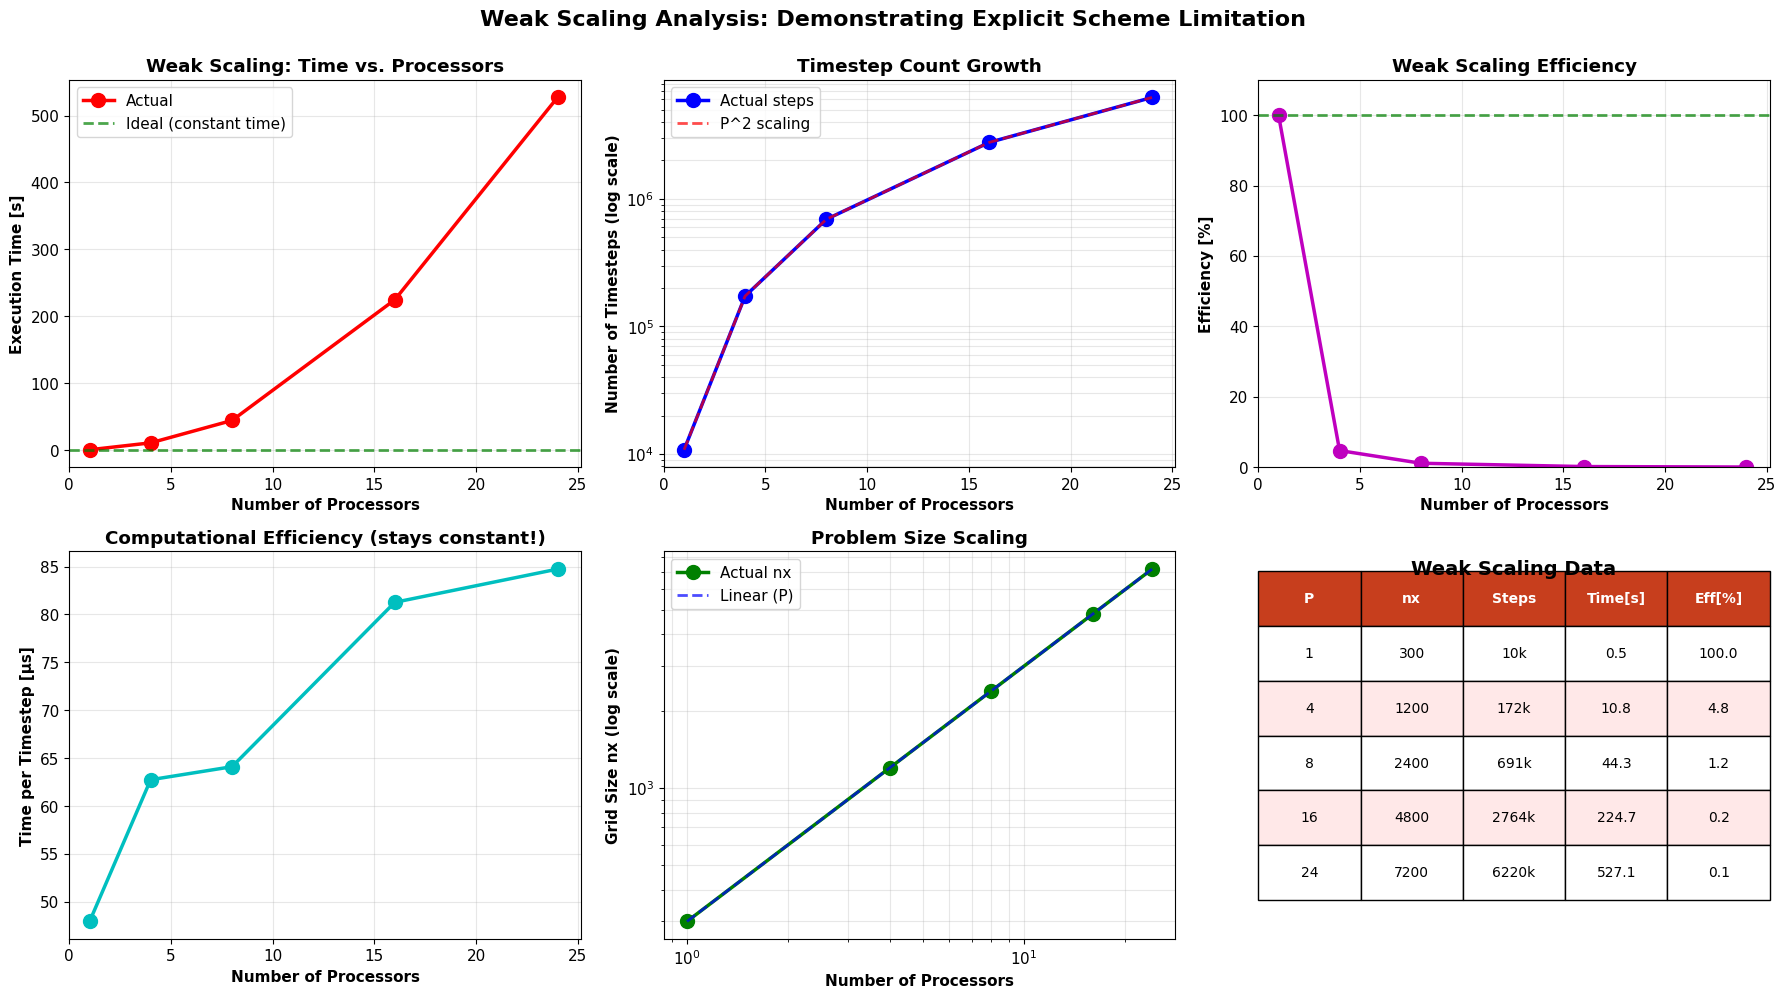


WEAK SCALING ANALYSIS
Efficiency at P=24: 0.10%
Time increased: 1017.7x (should be ~1x)
Steps increased: 576.0x (explains the time increase!)

Conclusion: Weak scaling fails due to dt ~ dx^2 constraint.
This is a fundamental limitation of explicit schemes, not a bug.



In [25]:
if weak_results and len(weak_results) > 0:
    # Create comprehensive weak scaling plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Weak Scaling Analysis: Demonstrating Explicit Scheme Limitation', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    procs = sorted(weak_results.keys())
    times = [weak_results[p]['time'] for p in procs]
    steps = [weak_results[p]['n_steps'] for p in procs]
    grid_sizes = [weak_results[p]['nx'] for p in procs]
    
    if 1 in weak_results:
        t_baseline = weak_results[1]['time']
        efficiencies = [(t_baseline / t) * 100 for t in times]
    else:
        efficiencies = [100] * len(procs)
    
    # Plot 1: Execution time (shows the problem)
    ax = axes[0, 0]
    ax.plot(procs, times, 'ro-', linewidth=2.5, markersize=10, label='Actual')
    if 1 in weak_results:
        ax.axhline(y=t_baseline, color='g', linestyle='--', linewidth=2, 
                  label='Ideal (constant time)', alpha=0.7)
    ax.set_xlabel('Number of Processors', fontweight='bold')
    ax.set_ylabel('Execution Time [s]', fontweight='bold')
    ax.set_title('Weak Scaling: Time vs. Processors', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    
    # Plot 2: Number of timesteps (shows P^2 growth)
    ax = axes[0, 1]
    ax.semilogy(procs, steps, 'bo-', linewidth=2.5, markersize=10, label='Actual steps')
    # Show quadratic growth
    if len(procs) > 1:
        p_ref = procs[0]
        steps_ref = steps[0]
        quadratic = [steps_ref * (p/p_ref)**2 for p in procs]
        ax.semilogy(procs, quadratic, 'r--', linewidth=2, 
                   label='P^2 scaling', alpha=0.7)
    ax.set_xlabel('Number of Processors', fontweight='bold')
    ax.set_ylabel('Number of Timesteps (log scale)', fontweight='bold')
    ax.set_title('Timestep Count Growth', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, which='both')
    ax.set_xlim(left=0)
    
    # Plot 3: Efficiency (shows the catastrophe)
    ax = axes[0, 2]
    ax.plot(procs, efficiencies, 'mo-', linewidth=2.5, markersize=10)
    ax.axhline(y=100, color='g', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xlabel('Number of Processors', fontweight='bold')
    ax.set_ylabel('Efficiency [%]', fontweight='bold')
    ax.set_title('Weak Scaling Efficiency', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    ax.set_ylim([0, 110])
    
    # Plot 4: Time per timestep (shows parallelization works)
    ax = axes[1, 0]
    time_per_step = [times[i] / steps[i] * 1e6 for i in range(len(procs))]  # microseconds
    ax.plot(procs, time_per_step, 'co-', linewidth=2.5, markersize=10)
    ax.set_xlabel('Number of Processors', fontweight='bold')
    ax.set_ylabel('Time per Timestep [μs]', fontweight='bold')
    ax.set_title('Computational Efficiency (stays constant!)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    
    # Plot 5: Grid size scaling
    ax = axes[1, 1]
    ax.loglog(procs, grid_sizes, 'go-', linewidth=2.5, markersize=10, label='Actual nx')
    # Linear scaling line
    if len(procs) > 1:
        linear = [grid_sizes[0] * (p / procs[0]) for p in procs]
        ax.loglog(procs, linear, 'b--', linewidth=2, label='Linear (P)', alpha=0.7)
    ax.set_xlabel('Number of Processors', fontweight='bold')
    ax.set_ylabel('Grid Size nx (log scale)', fontweight='bold')
    ax.set_title('Problem Size Scaling', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, which='both')
    
    # Plot 6: Summary table
    ax = axes[1, 2]
    ax.axis('off')
    
    table_data = [['P', 'nx', 'Steps', 'Time[s]', 'Eff[%]']]
    for i, p in enumerate(procs):
        table_data.append([
            f"{p}",
            f"{grid_sizes[i]}",
            f"{steps[i]//1000}k",
            f"{times[i]:.1f}",
            f"{efficiencies[i]:.1f}"
        ])
    
    table = ax.table(cellText=table_data, cellLoc='center', loc='center', bbox=[0, 0.1, 1, 0.85])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.2)
    
    for i in range(5):
        table[(0, i)].set_facecolor('#C73E1D')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for i in range(1, len(table_data)):
        color = '#FFE8E8' if i % 2 == 0 else 'white'
        for j in range(5):
            table[(i, j)].set_facecolor(color)
    
    ax.text(0.5, 0.98, 'Weak Scaling Data', ha='center', va='top',
           fontsize=14, fontweight='bold', transform=ax.transAxes)
    
    plt.tight_layout()
    output_file = 'plots/WEAK_SCALING_LIMITATION.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n[OK] Saved: {output_file}")
    plt.show()
    
    print(f"\n{'='*70}")
    print("WEAK SCALING ANALYSIS")
    print(f"{'='*70}")
    if 1 in weak_results:
        max_p = max(procs)
        max_eff = efficiencies[-1]
        print(f"Efficiency at P={max_p}: {max_eff:.2f}%")
        print(f"Time increased: {times[-1]/times[0]:.1f}x (should be ~1x)")
        print(f"Steps increased: {steps[-1]/steps[0]:.1f}x (explains the time increase!)")
        print(f"\nConclusion: Weak scaling fails due to dt ~ dx^2 constraint.")
        print(f"This is a fundamental limitation of explicit schemes, not a bug.")
    print(f"{'='*70}\n")
else:
    print("[Note] Weak scaling data not available - skipping weak scaling plots")

## Strong Scaling Performance Analysis

In [26]:
# Calculate metrics for each grid size
print("\n" + "="*80)
print("STRONG SCALING PERFORMANCE")
print("="*80)

for nx in sorted(strong_results.keys()):
    data = strong_results[nx]
    if 1 not in data:
        print(f"\nWarning: No baseline (P=1) for nx={nx}")
        continue
    
    print(f"\n{'='*80}")
    print(f"Grid size: nx={nx}")
    print(f"{'='*80}")
    
    t_seq = data[1]['time']
    n_steps = data[1]['n_steps']
    
    print(f"Sequential time: {t_seq:.2f}s ({n_steps} timesteps)\n")
    print(f"{'P':>4} {'Time[s]':>10} {'Speedup':>10} {'Efficiency':>12} {'cells/proc':>12}")
    print("-" * 80)
    
    for p in sorted(data.keys()):
        t = data[p]['time']
        speedup = t_seq / t
        efficiency = (speedup / p) * 100
        cells_per_proc = nx // p
        
        print(f"{p:4d} {t:10.2f} {speedup:10.2f} {efficiency:11.1f}% {cells_per_proc:12d}")
    
    max_p = max(data.keys())
    max_speedup = t_seq / data[max_p]['time']
    max_eff = (max_speedup / max_p) * 100
    
    print("-" * 80)
    print(f"Best speedup: {max_speedup:.2f}x with P={max_p} (efficiency: {max_eff:.1f}%)")

print("\n" + "="*80)


STRONG SCALING PERFORMANCE

Grid size: nx=1200
Sequential time: 10.26s (172800 timesteps)

   P    Time[s]    Speedup   Efficiency   cells/proc
--------------------------------------------------------------------------------
   1      10.26       1.00       100.0%         1200
   2      11.08       0.93        46.3%          600
   4      10.67       0.96        24.0%          300
   8      10.80       0.95        11.9%          150
--------------------------------------------------------------------------------
Best speedup: 0.95x with P=8 (efficiency: 11.9%)

Grid size: nx=2400
Sequential time: 46.31s (691201 timesteps)

   P    Time[s]    Speedup   Efficiency   cells/proc
--------------------------------------------------------------------------------
   1      46.31       1.00       100.0%         2400
   4      47.24       0.98        24.5%          600
   8      44.31       1.05        13.1%          300
  16      58.28       0.79         5.0%          150
----------------------

## Comprehensive Strong Scaling Plots


[OK] Saved: plots/STRONG_SCALING_ANALYSIS.png


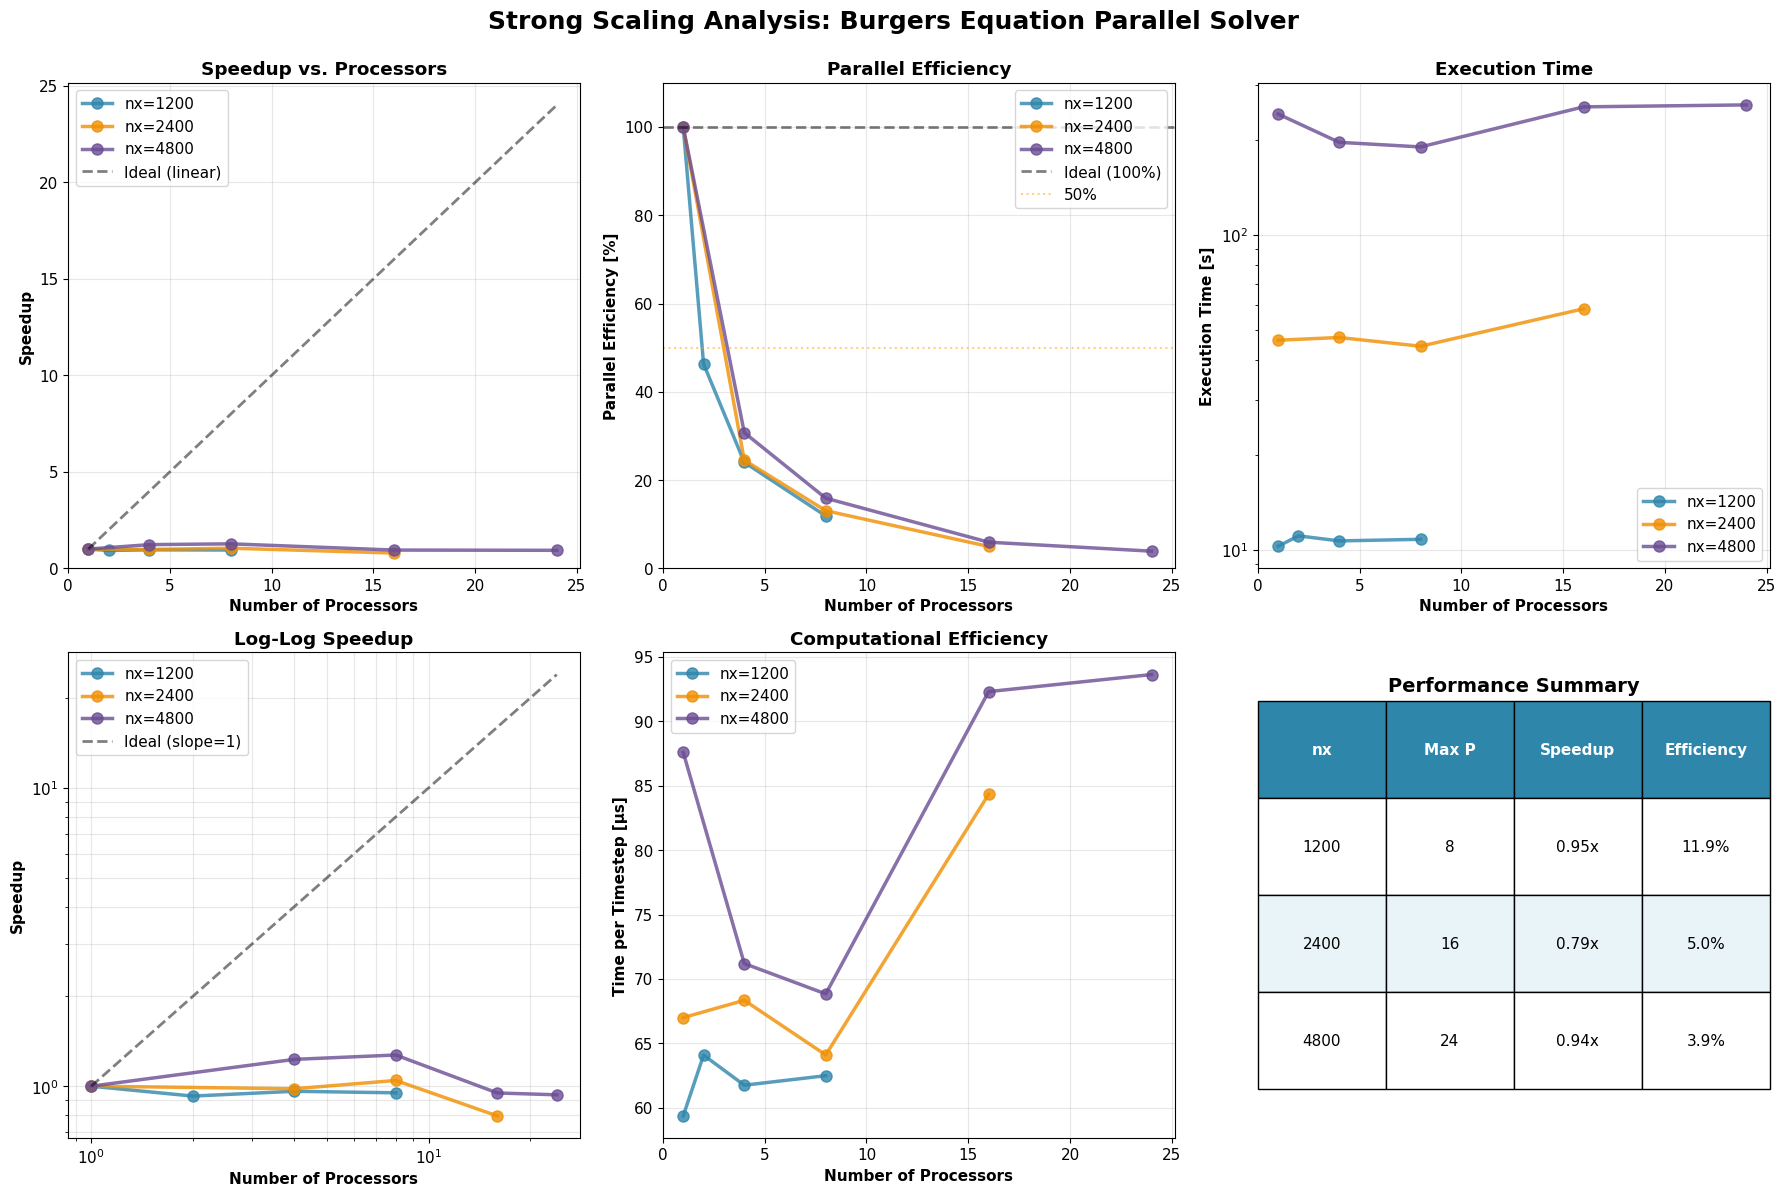

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Strong Scaling Analysis: Burgers Equation Parallel Solver', 
             fontsize=18, fontweight='bold', y=0.995)

colors = ['#2E86AB', '#F18F01', '#6A4C93', '#C73E1D']

# Prepare data for all plots
all_speedups = {}
all_efficiencies = {}
all_times = {}
all_procs = {}

for nx in sorted(strong_results.keys()):
    data = strong_results[nx]
    if 1 not in data:
        continue
    
    procs = sorted(data.keys())
    t_seq = data[1]['time']
    
    all_procs[nx] = procs
    all_times[nx] = [data[p]['time'] for p in procs]
    all_speedups[nx] = [t_seq / data[p]['time'] for p in procs]
    all_efficiencies[nx] = [(t_seq / data[p]['time']) / p * 100 for p in procs]

# Plot 1: Speedup
ax = axes[0, 0]
for idx, nx in enumerate(sorted(all_speedups.keys())):
    ax.plot(all_procs[nx], all_speedups[nx], 'o-', linewidth=2.5, markersize=8,
           color=colors[idx % len(colors)], label=f'nx={nx}', alpha=0.8)

max_p = max([max(all_procs[nx]) for nx in all_procs])
ax.plot([1, max_p], [1, max_p], 'k--', linewidth=2, alpha=0.5, label='Ideal (linear)')
ax.set_xlabel('Number of Processors', fontweight='bold')
ax.set_ylabel('Speedup', fontweight='bold')
ax.set_title('Speedup vs. Processors', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Plot 2: Efficiency
ax = axes[0, 1]
for idx, nx in enumerate(sorted(all_efficiencies.keys())):
    ax.plot(all_procs[nx], all_efficiencies[nx], 'o-', linewidth=2.5, markersize=8,
           color=colors[idx % len(colors)], label=f'nx={nx}', alpha=0.8)

ax.axhline(y=100, color='k', linestyle='--', linewidth=2, alpha=0.5, label='Ideal (100%)')
ax.axhline(y=50, color='orange', linestyle=':', linewidth=1.5, alpha=0.5, label='50%')
ax.set_xlabel('Number of Processors', fontweight='bold')
ax.set_ylabel('Parallel Efficiency [%]', fontweight='bold')
ax.set_title('Parallel Efficiency', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(left=0)
ax.set_ylim([0, 110])

# Plot 3: Execution time
ax = axes[0, 2]
for idx, nx in enumerate(sorted(all_times.keys())):
    ax.plot(all_procs[nx], all_times[nx], 'o-', linewidth=2.5, markersize=8,
           color=colors[idx % len(colors)], label=f'nx={nx}', alpha=0.8)

ax.set_xlabel('Number of Processors', fontweight='bold')
ax.set_ylabel('Execution Time [s]', fontweight='bold')
ax.set_title('Execution Time', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.set_xlim(left=0)

# Plot 4: Speedup (log-log)
ax = axes[1, 0]
for idx, nx in enumerate(sorted(all_speedups.keys())):
    ax.loglog(all_procs[nx], all_speedups[nx], 'o-', linewidth=2.5, markersize=8,
             color=colors[idx % len(colors)], label=f'nx={nx}', alpha=0.8)

ax.loglog([1, max_p], [1, max_p], 'k--', linewidth=2, alpha=0.5, label='Ideal (slope=1)')
ax.set_xlabel('Number of Processors', fontweight='bold')
ax.set_ylabel('Speedup', fontweight='bold')
ax.set_title('Log-Log Speedup', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

# Plot 5: Time per timestep
ax = axes[1, 1]
for idx, nx in enumerate(sorted(strong_results.keys())):
    data = strong_results[nx]
    if 1 not in data:
        continue
    procs = sorted(data.keys())
    time_per_step = [(data[p]['time'] / data[p]['n_steps']) * 1e6 for p in procs]  # μs
    ax.plot(procs, time_per_step, 'o-', linewidth=2.5, markersize=8,
           color=colors[idx % len(colors)], label=f'nx={nx}', alpha=0.8)

ax.set_xlabel('Number of Processors', fontweight='bold')
ax.set_ylabel('Time per Timestep [μs]', fontweight='bold')
ax.set_title('Computational Efficiency', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(left=0)

# Plot 6: Summary table
ax = axes[1, 2]
ax.axis('off')

table_data = [['nx', 'Max P', 'Speedup', 'Efficiency']]
for nx in sorted(strong_results.keys()):
    data = strong_results[nx]
    if 1 not in data:
        continue
    max_p = max(data.keys())
    speedup = data[1]['time'] / data[max_p]['time']
    efficiency = (speedup / max_p) * 100
    
    
    table_data.append([
        f"{nx}",
        f"{max_p}",
        f"{speedup:.2f}x",
        f"{efficiency:.1f}%"
    ])

table = ax.table(cellText=table_data, cellLoc='center', loc='center', bbox=[0, 0.1, 1, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for i in range(4):
    table[(0, i)].set_facecolor('#2E86AB')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(table_data)):
    color = '#E8F4F8' if i % 2 == 0 else 'white'
    for j in range(4):
        table[(i, j)].set_facecolor(color)

ax.text(0.5, 0.95, 'Performance Summary', ha='center', va='top',
       fontsize=14, fontweight='bold', transform=ax.transAxes)

plt.tight_layout()
output_file = 'plots/STRONG_SCALING_ANALYSIS.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n[OK] Saved: {output_file}")
plt.show()

## Shock Wave Visualization

[OK] Saved: plots/burgers_shock_step_nu001_visualization.png


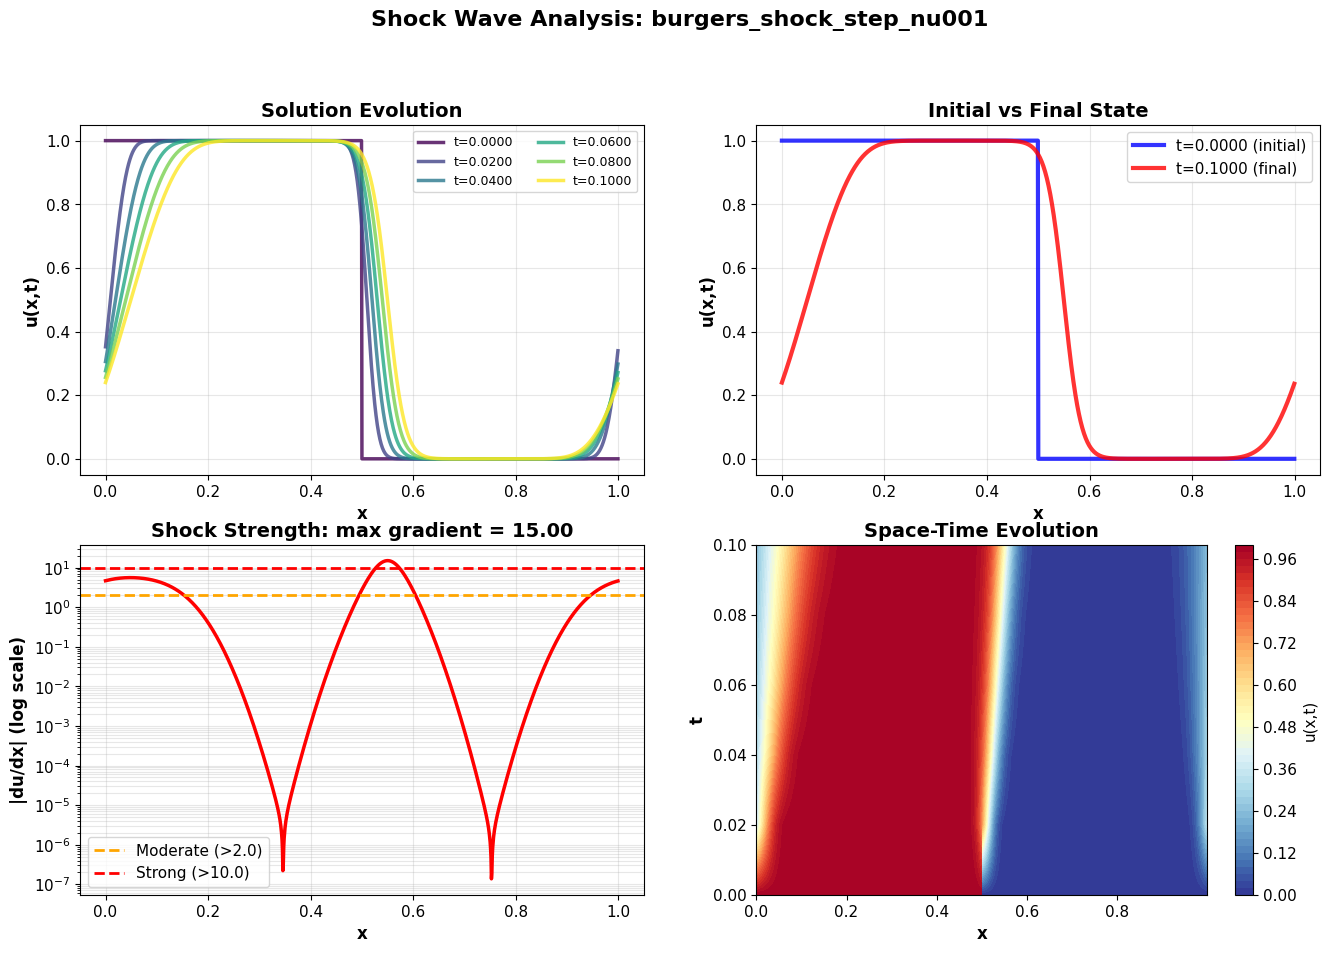


Shock Analysis: burgers_shock_step_nu001
Maximum gradient: 15.0047
[OK] STRONG shock wave detected!



In [28]:
for shock_file in shock_files:
    data = np.load(shock_file)
    x = data['x']
    snapshots = data['snapshots']
    times = data['times']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Solution evolution
    n_plot = min(len(snapshots), 10)
    indices = np.linspace(0, len(snapshots)-1, n_plot, dtype=int)
    colors = plt.cm.viridis(np.linspace(0, 1, n_plot))
    
    for i, idx in enumerate(indices):
        ax1.plot(x, snapshots[idx], linewidth=2.5, color=colors[i],
                label=f't={times[idx]:.4f}', alpha=0.8)
    
    ax1.set_xlabel('x', fontweight='bold', fontsize=12)
    ax1.set_ylabel('u(x,t)', fontweight='bold', fontsize=12)
    ax1.set_title('Solution Evolution', fontweight='bold', fontsize=14)
    ax1.legend(ncol=2, fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # 2. Initial vs Final
    ax2.plot(x, snapshots[0], 'b-', linewidth=3, label=f't={times[0]:.4f} (initial)', alpha=0.8)
    ax2.plot(x, snapshots[-1], 'r-', linewidth=3, label=f't={times[-1]:.4f} (final)', alpha=0.8)
    ax2.set_xlabel('x', fontweight='bold', fontsize=12)
    ax2.set_ylabel('u(x,t)', fontweight='bold', fontsize=12)
    ax2.set_title('Initial vs Final State', fontweight='bold', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Gradient magnitude (shock indicator)
    gradients = np.abs(np.gradient(snapshots[-1], x))
    max_grad = np.max(gradients)
    
    ax3.semilogy(x, gradients + 1e-10, 'r-', linewidth=2.5)
    ax3.axhline(y=2.0, color='orange', linestyle='--', linewidth=2, label='Moderate (>2.0)')
    ax3.axhline(y=10.0, color='red', linestyle='--', linewidth=2, label='Strong (>10.0)')
    ax3.set_xlabel('x', fontweight='bold', fontsize=12)
    ax3.set_ylabel('|du/dx| (log scale)', fontweight='bold', fontsize=12)
    ax3.set_title(f'Shock Strength: max gradient = {max_grad:.2f}', fontweight='bold', fontsize=14)
    ax3.legend()
    ax3.grid(True, alpha=0.3, which='both')
    
    # 4. Space-time evolution
    X, T = np.meshgrid(x, times)
    im = ax4.contourf(X, T, snapshots, levels=50, cmap='RdYlBu_r')
    plt.colorbar(im, ax=ax4, label='u(x,t)')
    ax4.set_xlabel('x', fontweight='bold', fontsize=12)
    ax4.set_ylabel('t', fontweight='bold', fontsize=12)
    ax4.set_title('Space-Time Evolution', fontweight='bold', fontsize=14)
    
    filename = shock_file.stem
    plt.suptitle(f'Shock Wave Analysis: {filename}', fontsize=16, fontweight='bold', y=0.995)
    
    output_file = f'plots/{filename}_visualization.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[OK] Saved: {output_file}")
    plt.show()
    
    # Shock detection
    print(f"\n{'='*60}")
    print(f"Shock Analysis: {filename}")
    print(f"{'='*60}")
    print(f"Maximum gradient: {max_grad:.4f}")
    if max_grad > 10:
        print("[OK] STRONG shock wave detected!")
    elif max_grad > 2:
        print("[OK] MODERATE discontinuity detected")
    else:
        print("approx Smooth solution")
    print(f"{'='*60}\n")

## Physical Field Visualization: Heatmaps

Heatmaps showing the evolution of the velocity field u(x,t) over space and time. These visualizations help identify shock formation, wave propagation, and solution smoothness.

Generating physical field heatmaps...


Generating heatmaps for burgers_shock_step_nu001.npz...
[OK] Saved: plots/burgers_shock_step_nu001_heatmaps.png


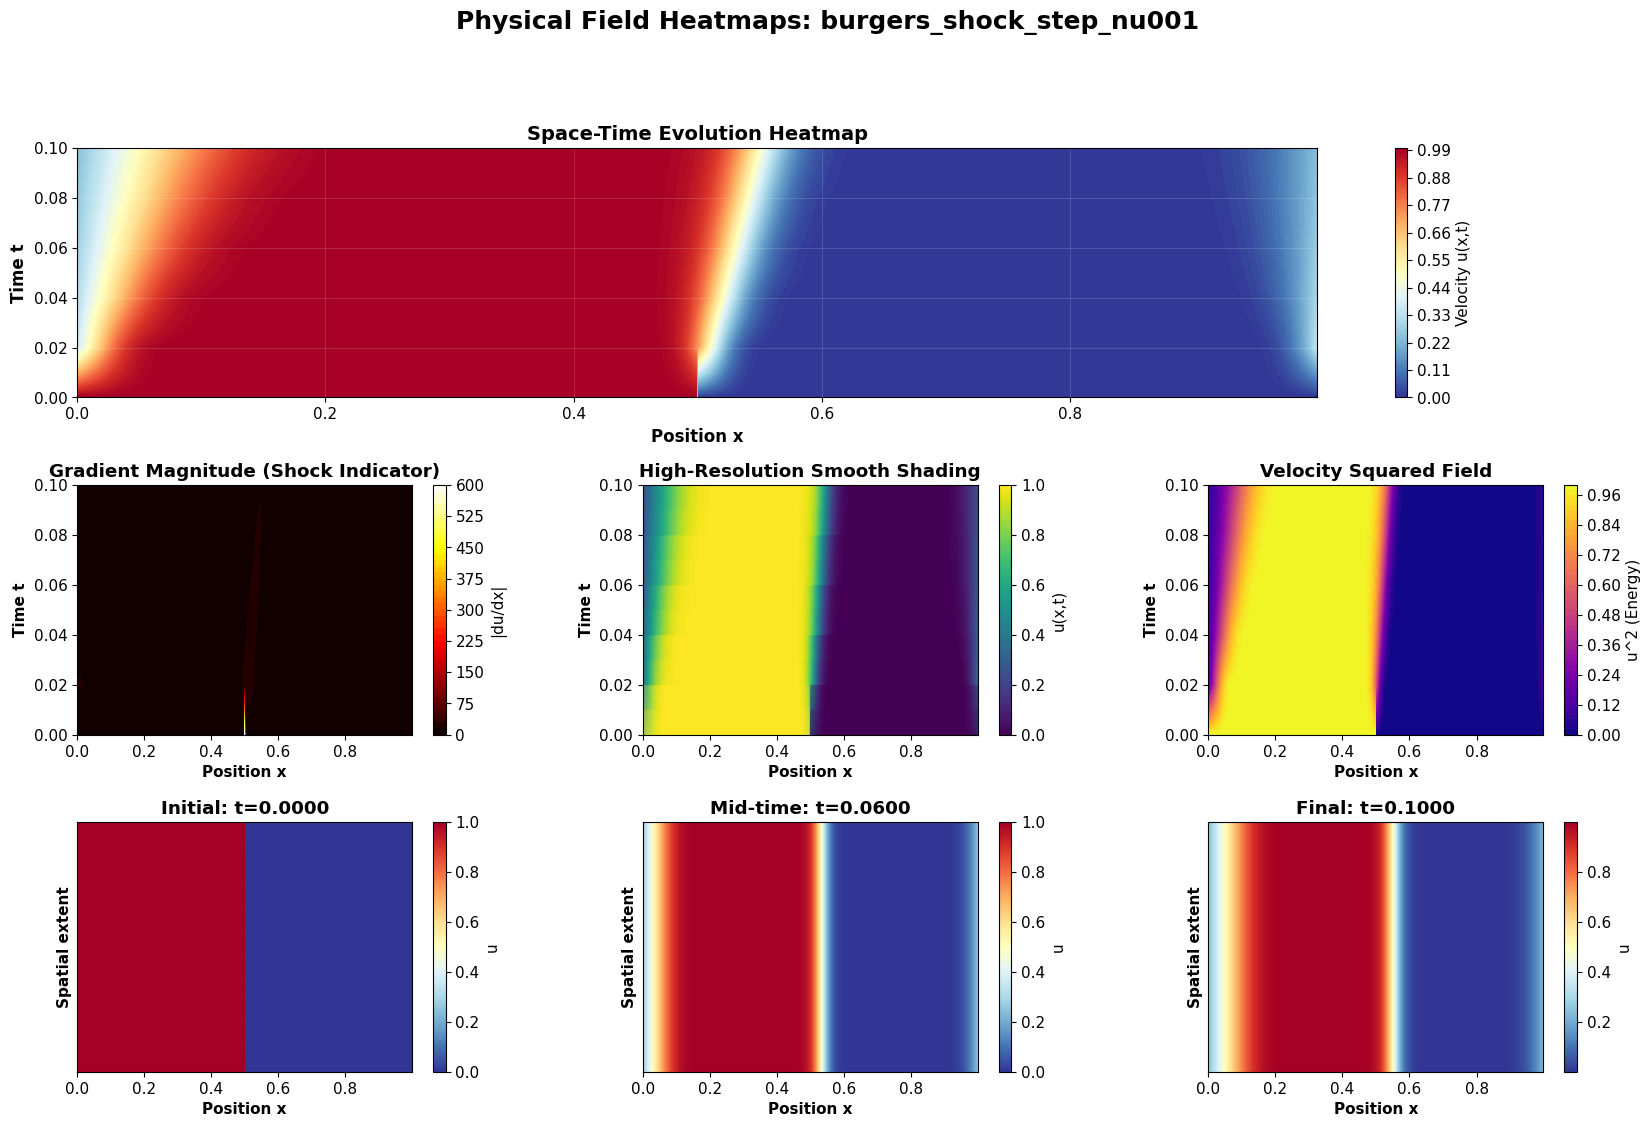


Generating heatmaps for regular solution (nx=4800)...
[OK] Saved: plots/burgers_strong_nx4800_P1_heatmaps.png


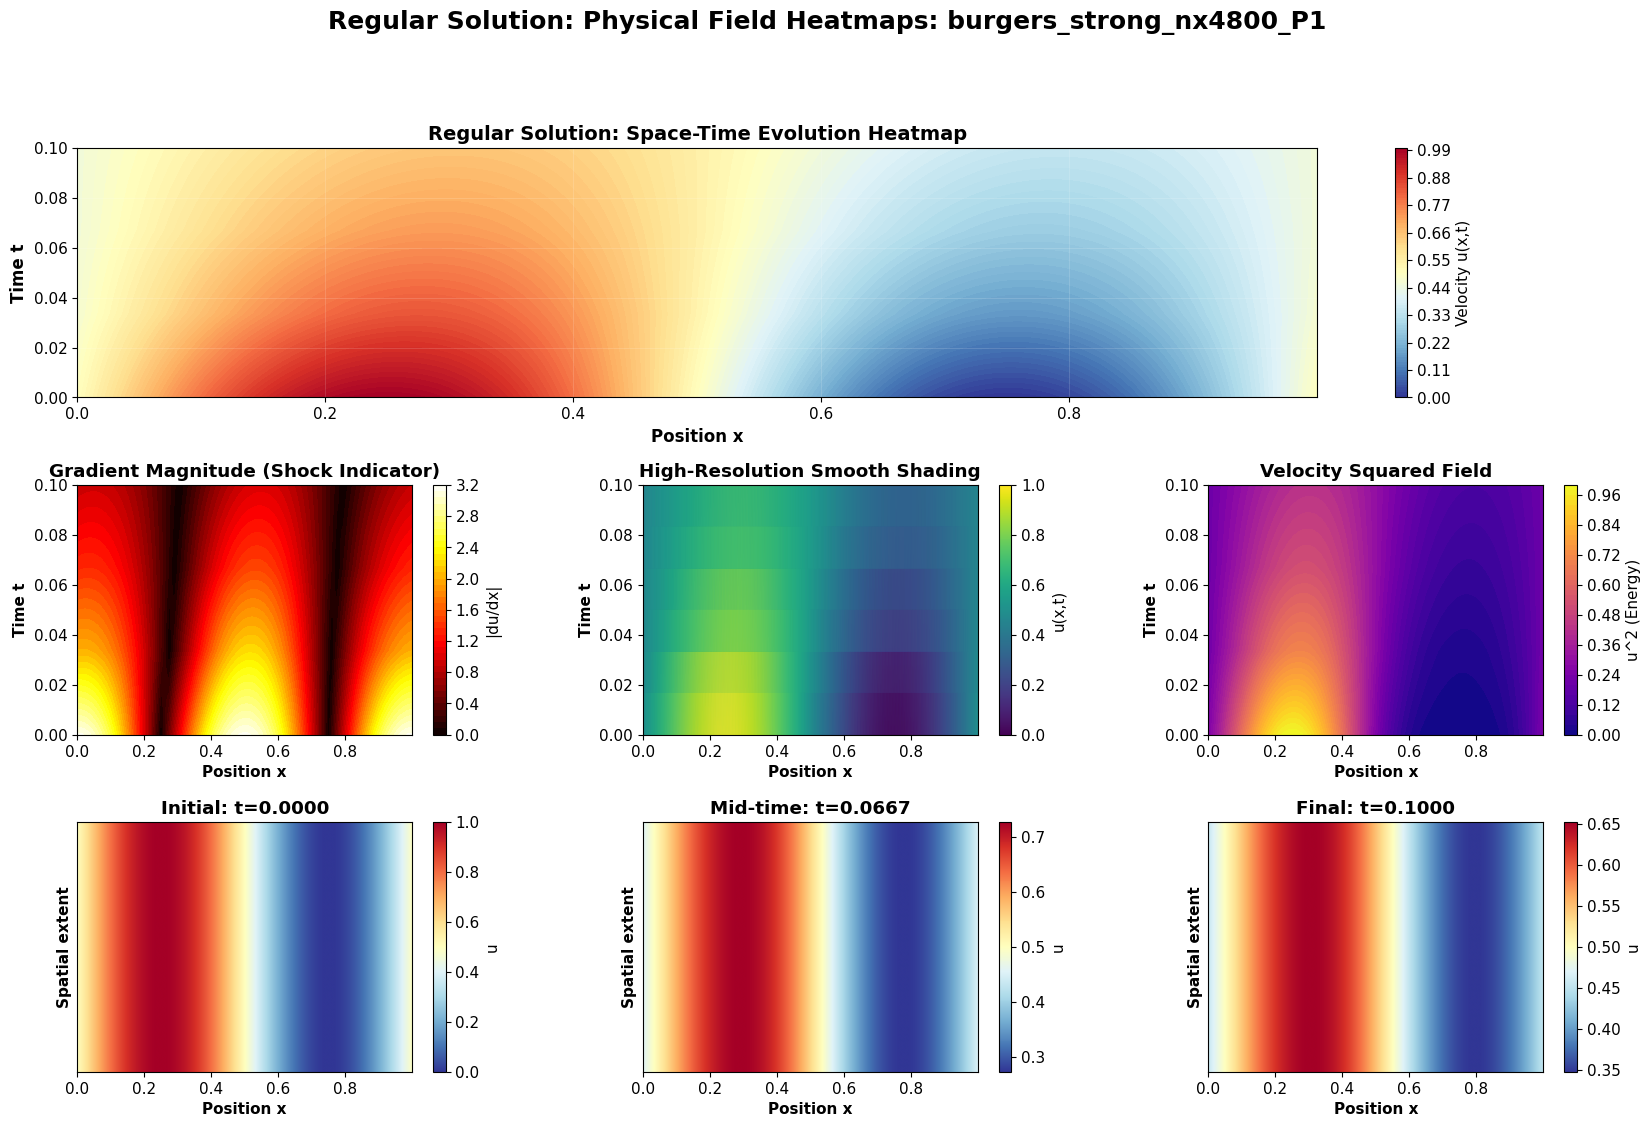


Generated 2 heatmap visualizations


In [29]:
# Generate comprehensive heatmap visualizations
print("Generating physical field heatmaps...\n")

# Function to create heatmaps for a given result file
def create_heatmaps(result_file, title_prefix=""):
    data = np.load(result_file)
    x = data['x']
    snapshots = data['snapshots']
    times = data['times']
    
    # Create figure with multiple heatmap views
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)
    
    # 1. Main space-time heatmap (large, top row)
    ax1 = fig.add_subplot(gs[0, :])
    X, T = np.meshgrid(x, times)
    im1 = ax1.contourf(X, T, snapshots, levels=100, cmap='RdYlBu_r')
    cb1 = plt.colorbar(im1, ax=ax1, label='Velocity u(x,t)')
    ax1.set_xlabel('Position x', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Time t', fontweight='bold', fontsize=12)
    ax1.set_title(f'{title_prefix}Space-Time Evolution Heatmap', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.2, color='white', linewidth=0.5)
    
    # 2. Gradient magnitude heatmap
    ax2 = fig.add_subplot(gs[1, 0])
    gradients = np.array([np.abs(np.gradient(snap, x)) for snap in snapshots])
    im2 = ax2.contourf(X, T, gradients, levels=50, cmap='hot')
    cb2 = plt.colorbar(im2, ax=ax2, label='|du/dx|')
    ax2.set_xlabel('Position x', fontweight='bold')
    ax2.set_ylabel('Time t', fontweight='bold')
    ax2.set_title('Gradient Magnitude (Shock Indicator)', fontweight='bold')
    
    # 3. High-resolution heatmap (pcolormesh for fine detail)
    ax3 = fig.add_subplot(gs[1, 1])
    im3 = ax3.pcolormesh(X, T, snapshots, shading='gouraud', cmap='viridis')
    cb3 = plt.colorbar(im3, ax=ax3, label='u(x,t)')
    ax3.set_xlabel('Position x', fontweight='bold')
    ax3.set_ylabel('Time t', fontweight='bold')
    ax3.set_title('High-Resolution Smooth Shading', fontweight='bold')
    
    # 4. Velocity squared (kinetic energy proxy)
    ax4 = fig.add_subplot(gs[1, 2])
    energy = snapshots**2
    im4 = ax4.contourf(X, T, energy, levels=50, cmap='plasma')
    cb4 = plt.colorbar(im4, ax=ax4, label='u^2 (Energy)')
    ax4.set_xlabel('Position x', fontweight='bold')
    ax4.set_ylabel('Time t', fontweight='bold')
    ax4.set_title('Velocity Squared Field', fontweight='bold')
    
    # 5-7. Snapshot heatmaps at different times
    snapshot_indices = [0, len(snapshots)//2, -1]
    snapshot_labels = ['Initial', 'Mid-time', 'Final']
    
    for idx, (snap_idx, label) in enumerate(zip(snapshot_indices, snapshot_labels)):
        ax = fig.add_subplot(gs[2, idx])
        # Create 2D representation by repeating the 1D solution
        field_2d = np.tile(snapshots[snap_idx], (20, 1))
        im = ax.imshow(field_2d, aspect='auto', cmap='RdYlBu_r', 
                      extent=[x[0], x[-1], 0, 1], origin='lower')
        cb = plt.colorbar(im, ax=ax, label='u')
        ax.set_xlabel('Position x', fontweight='bold')
        ax.set_ylabel('Spatial extent', fontweight='bold')
        ax.set_title(f'{label}: t={times[snap_idx]:.4f}', fontweight='bold')
        ax.set_yticks([])
    
    filename = result_file.stem
    plt.suptitle(f'{title_prefix}Physical Field Heatmaps: {filename}', 
                fontsize=18, fontweight='bold', y=0.995)
    
    output_file = f'plots/{filename}_heatmaps.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[OK] Saved: {output_file}")
    plt.show()
    
    return output_file

# Generate heatmaps for shock wave demonstrations
heatmap_files = []
for shock_file in shock_files:
    print(f"\nGenerating heatmaps for {shock_file.name}...")
    output = create_heatmaps(shock_file)
    heatmap_files.append(output)

# Also create heatmaps for one strong scaling case (to show regular solution)
if strong_results and 4800 in strong_results and 1 in strong_results[4800]:
    regular_file = RESULTS_DIR / 'burgers_strong_nx4800_P1.npz'
    if regular_file.exists():
        print(f"\nGenerating heatmaps for regular solution (nx=4800)...")
        output = create_heatmaps(regular_file, title_prefix="Regular Solution: ")
        heatmap_files.append(output)

print(f"\n{'='*70}")
print(f"Generated {len(heatmap_files)} heatmap visualizations")
print(f"{'='*70}")


Generating comparison heatmap...

[OK] Saved: plots/COMPARISON_regular_vs_shock_heatmaps.png


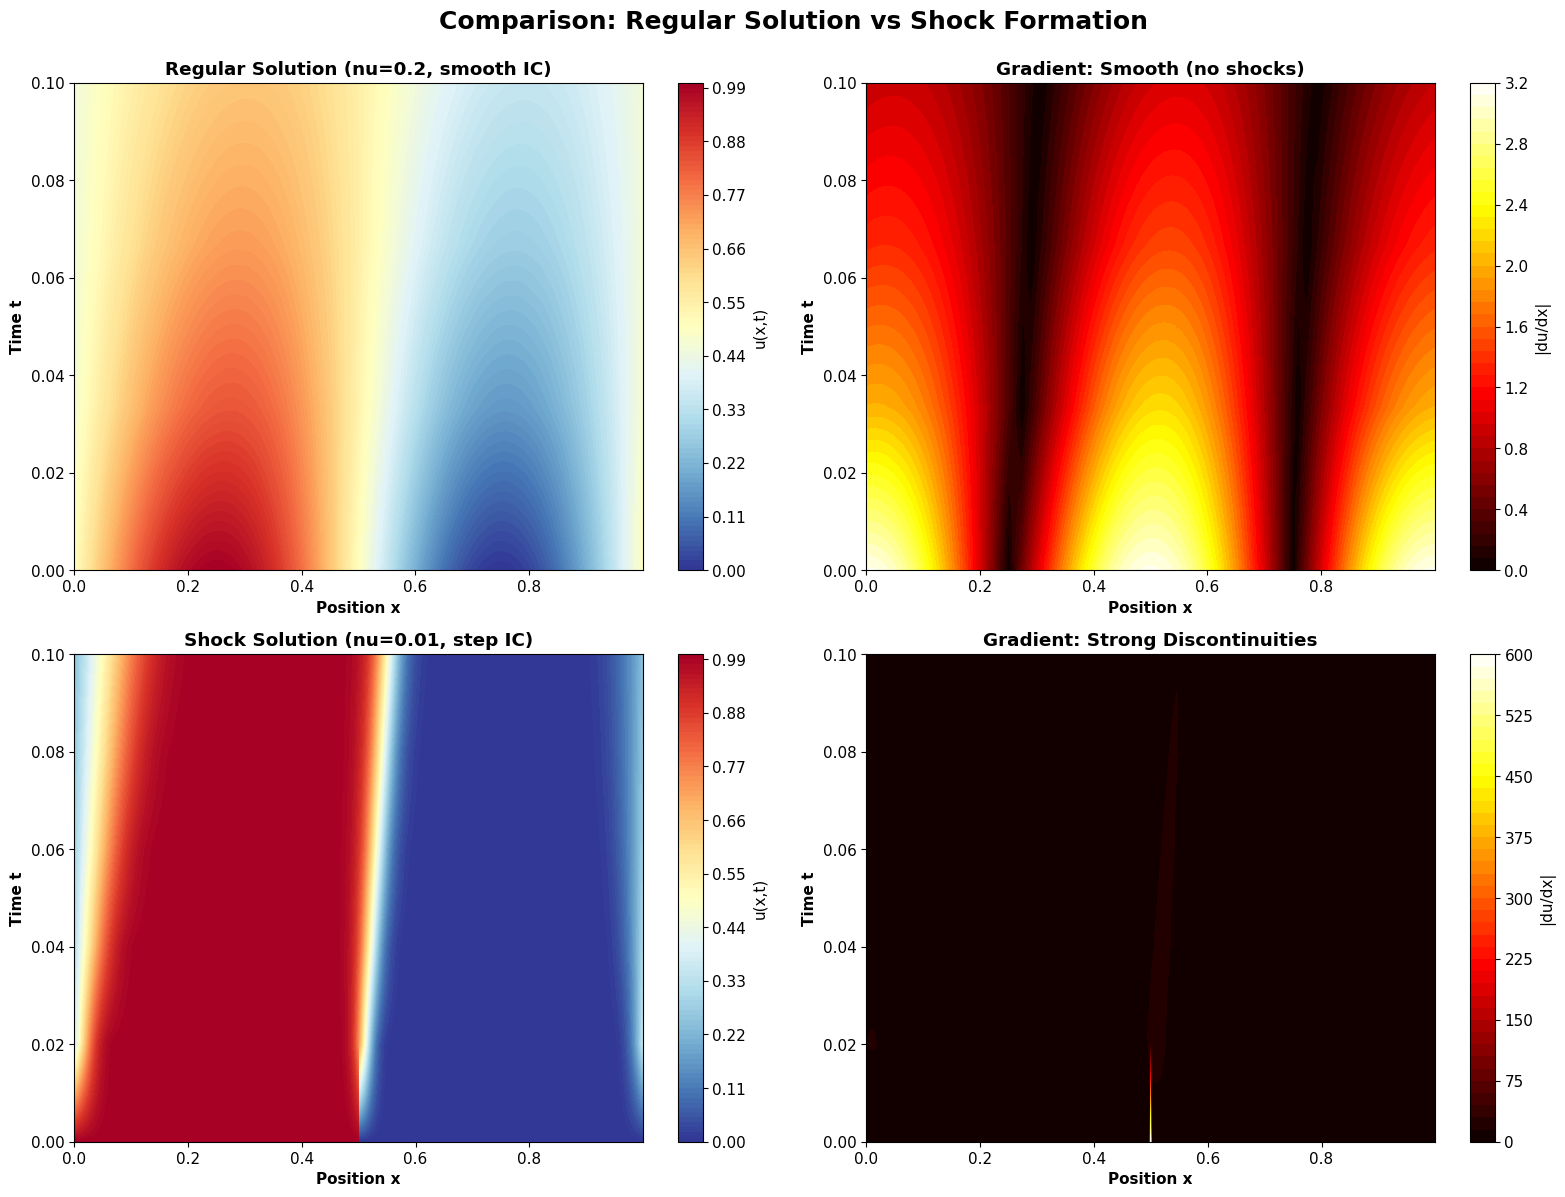

In [30]:
# Create side-by-side comparison of regular vs shock solutions
print("\nGenerating comparison heatmap...\n")

if len(shock_files) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comparison: Regular Solution vs Shock Formation', 
                fontsize=18, fontweight='bold', y=0.995)
    
    # Load regular solution (high viscosity)
    regular_file = RESULTS_DIR / 'burgers_strong_nx4800_P1.npz'
    if regular_file.exists():
        data_regular = np.load(regular_file)
        x_reg = data_regular['x']
        snaps_reg = data_regular['snapshots']
        times_reg = data_regular['times']
        X_reg, T_reg = np.meshgrid(x_reg, times_reg)
        
        # Regular solution heatmap
        ax = axes[0, 0]
        im = ax.contourf(X_reg, T_reg, snaps_reg, levels=100, cmap='RdYlBu_r')
        plt.colorbar(im, ax=ax, label='u(x,t)')
        ax.set_xlabel('Position x', fontweight='bold')
        ax.set_ylabel('Time t', fontweight='bold')
        ax.set_title('Regular Solution (nu=0.2, smooth IC)', fontweight='bold')
        
        # Gradient of regular solution
        ax = axes[0, 1]
        grads_reg = np.array([np.abs(np.gradient(s, x_reg)) for s in snaps_reg])
        im = ax.contourf(X_reg, T_reg, grads_reg, levels=50, cmap='hot')
        plt.colorbar(im, ax=ax, label='|du/dx|')
        ax.set_xlabel('Position x', fontweight='bold')
        ax.set_ylabel('Time t', fontweight='bold')
        ax.set_title('Gradient: Smooth (no shocks)', fontweight='bold')
    
    # Load shock solution (low viscosity)
    shock_data = np.load(shock_files[0])
    x_shock = shock_data['x']
    snaps_shock = shock_data['snapshots']
    times_shock = shock_data['times']
    X_shock, T_shock = np.meshgrid(x_shock, times_shock)
    
    # Shock solution heatmap
    ax = axes[1, 0]
    im = ax.contourf(X_shock, T_shock, snaps_shock, levels=100, cmap='RdYlBu_r')
    plt.colorbar(im, ax=ax, label='u(x,t)')
    ax.set_xlabel('Position x', fontweight='bold')
    ax.set_ylabel('Time t', fontweight='bold')
    shock_nu = shock_data.get('nu', 0.01)
    ax.set_title(f'Shock Solution (nu={shock_nu}, step IC)', fontweight='bold')
    
    # Gradient of shock solution
    ax = axes[1, 1]
    grads_shock = np.array([np.abs(np.gradient(s, x_shock)) for s in snaps_shock])
    im = ax.contourf(X_shock, T_shock, grads_shock, levels=50, cmap='hot')
    plt.colorbar(im, ax=ax, label='|du/dx|')
    ax.set_xlabel('Position x', fontweight='bold')
    ax.set_ylabel('Time t', fontweight='bold')
    ax.set_title('Gradient: Strong Discontinuities', fontweight='bold')
    
    plt.tight_layout()
    output_file = 'plots/COMPARISON_regular_vs_shock_heatmaps.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"[OK] Saved: {output_file}")
    plt.show()
else:
    print("[Note] No shock files available for comparison")